In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
import numpy as np
import os
import psycopg2
import sqlalchemy
import string
import spacy
from spacy.symbols import ORTH
import scispacy
from collections import Counter
import re
from datetime import date, datetime, timedelta
import random
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit
from spellchecker import SpellChecker
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
dbschema='mimiciii'
cnx = sqlalchemy.create_engine('postgresql+psycopg2://njolzisalnylqx:31b9211af0689fdc75c296546539fd3d86b8c8135d277924a0659bcfe735adb3\
@ec2-3-219-135-162.compute-1.amazonaws.com/d6di1ovvoadbog'
                    # connect_args={'options': '-csearch_path={}'.format(dbschema)}
                    )

In [3]:
sql = """
  SELECT
      "SUBJECT_ID", "HADM_ID","ETHNICITY", "DIAGNOSIS", "ADMITTIME","DISCHTIME", "DEATHTIME","ADMISSION_TYPE"
  FROM "ADMISSIONS"
  WHERE "ADMISSION_TYPE" NOT IN ('NEWBORN')
  ORDER BY "SUBJECT_ID","ADMITTIME"
  --LIMIT 100;
"""

df_adm = pd.read_sql_query(sqlalchemy.text(sql), cnx)
print(df_adm.shape)
df_adm.head(20)

(51113, 8)


,SUBJECT_ID,HADM_ID,ETHNICITY,DIAGNOSIS,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE
0,3,145834,WHITE,HYPOTENSION,2101-10-20 19:08:00,2101-10-31 13:58:00,None,EMERGENCY
1,4,185777,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-16 00:28:00,2191-03-23 18:41:00,None,EMERGENCY
2,6,107064,WHITE,CHRONIC RENAL FAILURE/SDA,2175-05-30 07:15:00,2175-06-15 16:00:00,None,ELECTIVE
3,9,150750,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY
4,11,194540,WHITE,BRAIN MASS,2178-04-16 06:18:00,2178-05-11 19:00:00,None,EMERGENCY
5,12,112213,WHITE,PANCREATIC CANCER/SDA,2104-08-07 10:15:00,2104-08-20 02:57:00,2104-08-20 02:57:00,ELECTIVE
6,13,143045,WHITE,CORONARY ARTERY DISEASE,2167-01-08 18:43:00,2167-01-15 15:15:00,None,EMERGENCY
7,17,194023,WHITE,PATIENT FORAMEN OVALE\ PATENT FORAMEN OVALE MI...,2134-12-27 07:15:00,2134-12-31 16:05:00,None,ELECTIVE
8,17,161087,WHITE,PERICARDIAL EFFUSION,2135-05-09 14:11:00,2135-05-13 14:40:00,None,EMERGENCY
9,18,188822,WHITE,HYPOGLYCEMIA;SEIZURES,2167-10-02 11:18:00,2167-10-04 16:15:00,None,EMERGENCY


In [4]:
df_adm['NEXT_ADMITTIME'] = df_adm.groupby("SUBJECT_ID").ADMITTIME.shift(-1)
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby("SUBJECT_ID").ADMISSION_TYPE.shift(-1)
df_adm.head(20)

,SUBJECT_ID,HADM_ID,ETHNICITY,DIAGNOSIS,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
0,3,145834,WHITE,HYPOTENSION,2101-10-20 19:08:00,2101-10-31 13:58:00,None,EMERGENCY,NaN,NaN
1,4,185777,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-16 00:28:00,2191-03-23 18:41:00,None,EMERGENCY,NaN,NaN
2,6,107064,WHITE,CHRONIC RENAL FAILURE/SDA,2175-05-30 07:15:00,2175-06-15 16:00:00,None,ELECTIVE,NaN,NaN
3,9,150750,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,NaN,NaN
4,11,194540,WHITE,BRAIN MASS,2178-04-16 06:18:00,2178-05-11 19:00:00,None,EMERGENCY,NaN,NaN
5,12,112213,WHITE,PANCREATIC CANCER/SDA,2104-08-07 10:15:00,2104-08-20 02:57:00,2104-08-20 02:57:00,ELECTIVE,NaN,NaN
6,13,143045,WHITE,CORONARY ARTERY DISEASE,2167-01-08 18:43:00,2167-01-15 15:15:00,None,EMERGENCY,NaN,NaN
7,17,194023,WHITE,PATIENT FORAMEN OVALE\ PATENT FORAMEN OVALE MI...,2134-12-27 07:15:00,2134-12-31 16:05:00,None,ELECTIVE,2135-05-09 14:11:00,EMERGENCY
8,17,161087,WHITE,PERICARDIAL EFFUSION,2135-05-09 14:11:00,2135-05-13 14:40:00,None,EMERGENCY,NaN,NaN
9,18,188822,WHITE,HYPOGLYCEMIA;SEIZURES,2167-10-02 11:18:00,2167-10-04 16:15:00,None,EMERGENCY,NaN,NaN


In [5]:
# get rows where next admission is elective and replace with naT or nan
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [6]:
# sort by subject_ID and admission date
# it is safer to sort right before the fill in case something changed the order above
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
# back fill (this will take a little while)
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])[['SUBJECT_ID','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [7]:
df_adm.NEXT_ADMITTIME

0            3
1            4
2            6
3            9
4           11
         ...  
51108    99985
51109    99991
51110    99992
51111    99995
51112    99999
Name: NEXT_ADMITTIME, Length: 51113, dtype: int64

In [8]:
# convert the 'Date' column to datetime format
df_adm["ADMITTIME"]= pd.to_datetime(df_adm["ADMITTIME"])
df_adm["DISCHTIME"]= pd.to_datetime(df_adm["DISCHTIME"])
df_adm["DEATHTIME"]= pd.to_datetime(df_adm["DEATHTIME"])
df_adm["NEXT_ADMITTIME"]= pd.to_datetime(df_adm["NEXT_ADMITTIME"])

In [9]:
df_adm['DAYS_NEXT_ADMIT']=  (df_adm['NEXT_ADMITTIME'] - df_adm['DISCHTIME']).dt.total_seconds()/(24*60*60)

In [10]:
print(len(df_adm))
df_adm.head(100)

51113


,SUBJECT_ID,HADM_ID,ETHNICITY,DIAGNOSIS,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT
0,3,145834,WHITE,HYPOTENSION,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,1970-01-01 00:00:00.000000003,NaN,-48150.581944
1,4,185777,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,1970-01-01 00:00:00.000000004,NaN,-80800.778472
2,6,107064,WHITE,CHRONIC RENAL FAILURE/SDA,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,1970-01-01 00:00:00.000000006,NaN,-75040.666667
3,9,150750,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,1970-01-01 00:00:00.000000009,NaN,-65696.427083
4,11,194540,WHITE,BRAIN MASS,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,1970-01-01 00:00:00.000000011,NaN,-76101.791667
...,...,...,...,...,...,...,...,...,...,...,...
95,109,110668,BLACK/AFRICAN AMERICAN,HYPERTENSION EMERGENCY,2140-08-25 14:39:00,2140-09-02 18:30:00,NaT,EMERGENCY,1970-01-01 00:00:00.000000109,EMERGENCY,-62336.770833
96,109,166018,BLACK/AFRICAN AMERICAN,HYPERTENSIVE CRISIS,2141-03-27 21:08:00,2141-03-28 17:45:00,NaT,EMERGENCY,1970-01-01 00:00:00.000000109,EMERGENCY,-62543.739583
97,109,170149,BLACK/AFRICAN AMERICAN,ACUTE RENAL FAILURE,2141-05-24 14:47:00,2141-06-06 19:55:00,NaT,EMERGENCY,1970-01-01 00:00:00.000000109,EMERGENCY,-62613.829861
98,109,147469,BLACK/AFRICAN AMERICAN,HYPERTENSIVE EMERGENCY,2141-06-11 10:17:00,2141-06-17 16:29:00,NaT,EMERGENCY,1970-01-01 00:00:00.000000109,EMERGENCY,-62624.686806


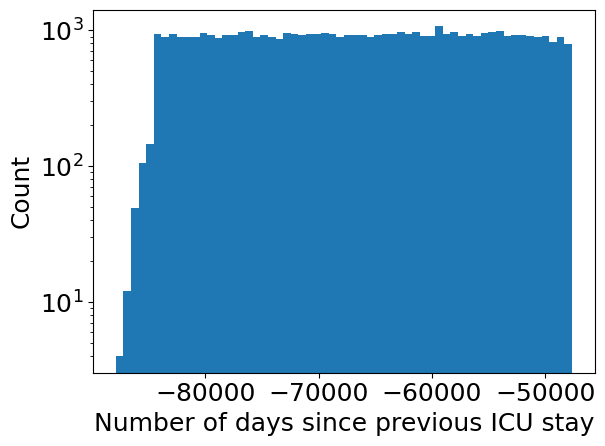

In [11]:
matplotlib.rcParams.update({'font.size': 18})

plt.hist(df_adm['DAYS_NEXT_ADMIT'], bins=60)
plt.ylabel('Count')
plt.xlabel('Number of days since previous ICU stay')
plt.yscale('log')
plt.tight_layout()
plt.savefig('readmission-histogram.pdf')

In [12]:
df_adm['30_D_UNPLAN_READMIT'] = 'N'
df_adm.loc[df_adm['DAYS_NEXT_ADMIT'] < 30, '30_D_UNPLAN_READMIT'] = 'Y'

In [13]:
df_adm.head(50)

,SUBJECT_ID,HADM_ID,ETHNICITY,DIAGNOSIS,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,30_D_UNPLAN_READMIT
0,3,145834,WHITE,HYPOTENSION,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,1970-01-01 00:00:00.000000003,NaN,-48150.581944,Y
1,4,185777,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,1970-01-01 00:00:00.000000004,NaN,-80800.778472,Y
2,6,107064,WHITE,CHRONIC RENAL FAILURE/SDA,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,1970-01-01 00:00:00.000000006,NaN,-75040.666667,Y
3,9,150750,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,1970-01-01 00:00:00.000000009,NaN,-65696.427083,Y
4,11,194540,WHITE,BRAIN MASS,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,1970-01-01 00:00:00.000000011,NaN,-76101.791667,Y
5,12,112213,WHITE,PANCREATIC CANCER/SDA,2104-08-07 10:15:00,2104-08-20 02:57:00,2104-08-20 02:57:00,ELECTIVE,1970-01-01 00:00:00.000000012,NaN,-49174.122917,Y
6,13,143045,WHITE,CORONARY ARTERY DISEASE,2167-01-08 18:43:00,2167-01-15 15:15:00,NaT,EMERGENCY,1970-01-01 00:00:00.000000013,NaN,-71967.635417,Y
7,17,194023,WHITE,PATIENT FORAMEN OVALE\ PATENT FORAMEN OVALE MI...,2134-12-27 07:15:00,2134-12-31 16:05:00,NaT,ELECTIVE,1970-01-01 00:00:00.000000017,EMERGENCY,-60264.670139,Y
8,17,161087,WHITE,PERICARDIAL EFFUSION,2135-05-09 14:11:00,2135-05-13 14:40:00,NaT,EMERGENCY,1970-01-01 00:00:00.000000017,NaN,-60397.611111,Y
9,18,188822,WHITE,HYPOGLYCEMIA;SEIZURES,2167-10-02 11:18:00,2167-10-04 16:15:00,NaT,EMERGENCY,1970-01-01 00:00:00.000000018,NaN,-72229.677083,Y


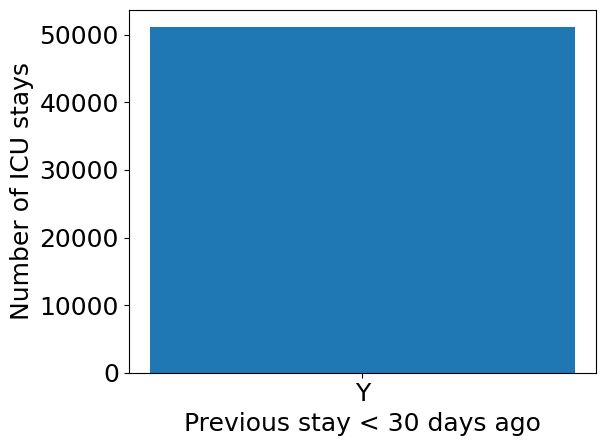

In [14]:
#df_adm['30d_unplan_readmit'].value_counts().plot(kind='bar')
plt.bar(df_adm['30_D_UNPLAN_READMIT'].unique(),height=df_adm['30_D_UNPLAN_READMIT'].value_counts())
plt.ylabel('Number of ICU stays')
plt.xlabel('Previous stay < 30 days ago')
plt.tight_layout()
plt.savefig('30d-readmission-bar.pdf')

In [15]:
readmit_count = df_adm.SUBJECT_ID[(df_adm['30_D_UNPLAN_READMIT']) == 'Y'].count()
ratio = readmit_count/df_adm['30_D_UNPLAN_READMIT'].count()
ratio

1.0

<AxesSubplot:>

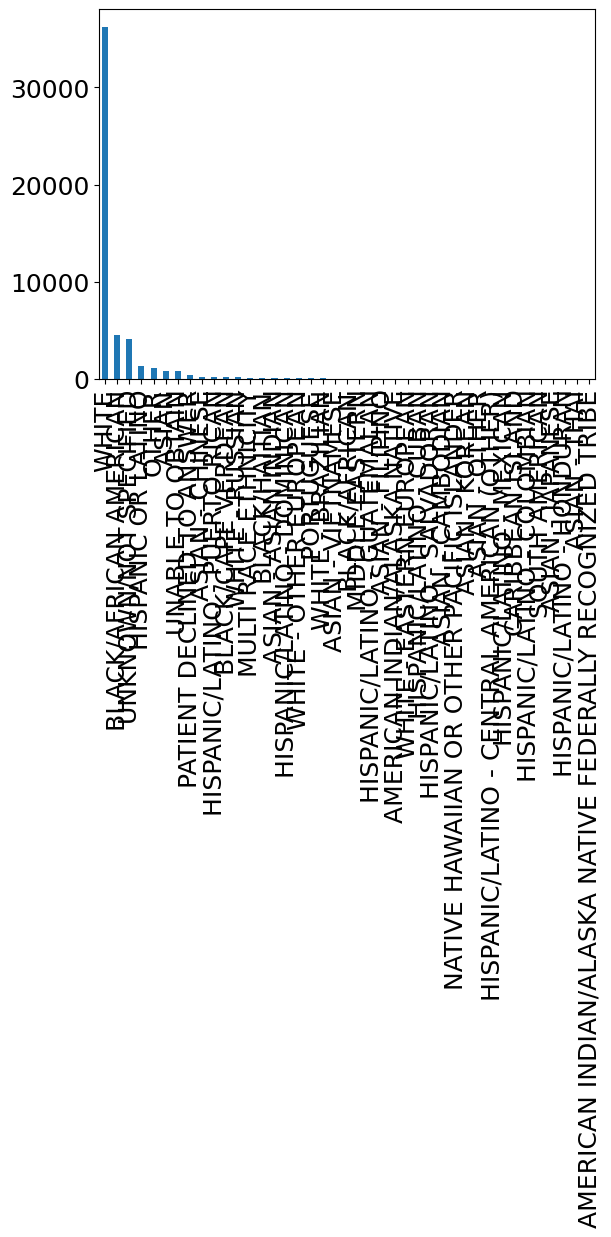

In [16]:
df_adm['ETHNICITY'].value_counts().plot(kind='bar')

In [17]:
sorted(df_adm.ETHNICITY.unique())

['AMERICAN INDIAN/ALASKA NATIVE',
 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
 'ASIAN',
 'ASIAN - ASIAN INDIAN',
 'ASIAN - CAMBODIAN',
 'ASIAN - CHINESE',
 'ASIAN - FILIPINO',
 'ASIAN - JAPANESE',
 'ASIAN - KOREAN',
 'ASIAN - OTHER',
 'ASIAN - THAI',
 'ASIAN - VIETNAMESE',
 'BLACK/AFRICAN',
 'BLACK/AFRICAN AMERICAN',
 'BLACK/CAPE VERDEAN',
 'BLACK/HAITIAN',
 'CARIBBEAN ISLAND',
 'HISPANIC OR LATINO',
 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
 'HISPANIC/LATINO - COLOMBIAN',
 'HISPANIC/LATINO - CUBAN',
 'HISPANIC/LATINO - DOMINICAN',
 'HISPANIC/LATINO - GUATEMALAN',
 'HISPANIC/LATINO - HONDURAN',
 'HISPANIC/LATINO - MEXICAN',
 'HISPANIC/LATINO - PUERTO RICAN',
 'HISPANIC/LATINO - SALVADORAN',
 'MIDDLE EASTERN',
 'MULTI RACE ETHNICITY',
 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
 'OTHER',
 'PATIENT DECLINED TO ANSWER',
 'PORTUGUESE',
 'SOUTH AMERICAN',
 'UNABLE TO OBTAIN',
 'UNKNOWN/NOT SPECIFIED',
 'WHITE',
 'WHITE - BRAZILIAN',
 'WHITE - EASTERN EUROPEAN',
 'WHI

In [18]:
asian = dict.fromkeys(['ASIAN','ASIAN - ASIAN INDIAN','ASIAN - CAMBODIAN','ASIAN - CHINESE','ASIAN - FILIPINO',
 'ASIAN - JAPANESE',
 'ASIAN - KOREAN',
 'ASIAN - OTHER',
 'ASIAN - THAI',
 'ASIAN - VIETNAMESE',
 'MIDDLE EASTERN'], 'asian')    
white = dict.fromkeys([ 'WHITE', 'WHITE - BRAZILIAN', 'WHITE - EASTERN EUROPEAN', 'WHITE - OTHER EUROPEAN', 'WHITE - RUSSIAN'], 'white')
black = dict.fromkeys([ 'BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN','BLACK/HAITIAN'], 'black')
hispanic = dict.fromkeys([ 'HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN',
 'HISPANIC/LATINO - CUBAN',
 'HISPANIC/LATINO - DOMINICAN',
 'HISPANIC/LATINO - GUATEMALAN',
 'HISPANIC/LATINO - HONDURAN',
 'HISPANIC/LATINO - MEXICAN',
 'HISPANIC/LATINO - PUERTO RICAN',
 'HISPANIC/LATINO - SALVADORAN',
 'PORTUGUESE',
 'SOUTH AMERICAN'], 'hispanic')

df_adm = df_adm.replace(asian)
df_adm = df_adm.replace(white)
df_adm = df_adm.replace(black)
df_adm = df_adm.replace(hispanic)

allowed_vals = ['asian', 'black', 'white', 'hispanic']
df_adm.loc[~df_adm['ETHNICITY'].isin(allowed_vals), 'ETHNICITY'] = "other"
sorted(df_adm.ETHNICITY.unique())

['asian', 'black', 'hispanic', 'other', 'white']

<AxesSubplot:>

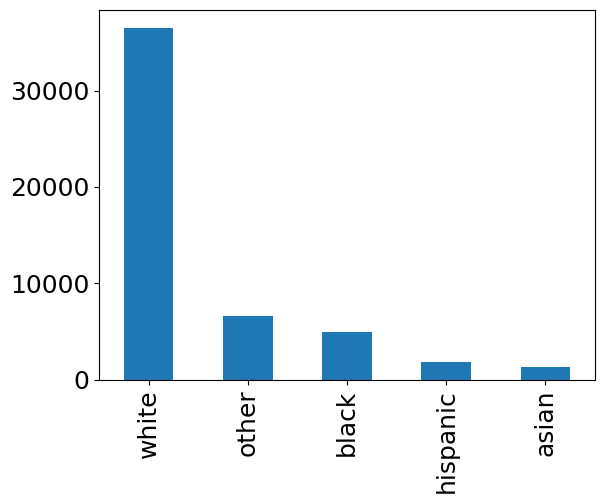

In [19]:
df_adm['ETHNICITY'].value_counts().plot(kind='bar')

In [20]:
df_adm.DIAGNOSIS = df_adm.DIAGNOSIS.apply(str)
print(df_adm.DIAGNOSIS)

0                                HYPOTENSION
1        FEVER,DEHYDRATION,FAILURE TO THRIVE
2                  CHRONIC RENAL FAILURE/SDA
3                            HEMORRHAGIC CVA
4                                 BRAIN MASS
                        ...                 
51108                                  FEVER
51109                     DIVERTICULITIS/SDA
51110             RETROPERITONEAL HEMORRHAGE
51111          ABDOMINAL AORTIC ANEURYSM/SDA
51112                  SPONDYLOLISTHESIS/SDA
Name: DIAGNOSIS, Length: 51113, dtype: object


In [21]:
df_adm_csv = df_adm[['SUBJECT_ID','HADM_ID', 'ETHNICITY','DIAGNOSIS','ADMISSION_TYPE','30_D_UNPLAN_READMIT']]

In [22]:
df_adm_csv.to_csv('../data/df_adm.csv',index=False)